In [1]:

import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
import os
from tqdm import tqdm
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
from solat_cb.simulation import CMB, BandpassInt, Foreground, Mask, Noise, LATsky, SATsky
from solat_cb.spectra import Spectra

In [3]:
lib ='/pscratch/sd/l/lonappan/SOLATcalib'
nside = 512
cb_method = 'iso'
beta = 0.35
dust = 10
synch = 5
alpha_sat = [0.05,0.05,-0.08,-0.08,.07,.07]
alpha_lat = [-0.1,-0.1,0.2,0.2,.15,.15]
atm_noise = True
nsplits = 1
bandpass = False
deconv_maps = True

In [4]:
lat = LATsky(lib,nside,cb_method,dust,synch,alpha_lat,beta,atm_noise=atm_noise,nsplits=nsplits,bandpass=bandpass,deconv_maps=deconv_maps)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected
Mask : INFO - Downgrading mask LAT resolution
Noise : INFO - Noise Model:[LAT] White + 1/f noise v3.1.1


In [5]:
latspectra = Spectra(lat,parallel=2,galcut=40,binwidth=5)

Mask : INFO - The given galactic cut value seems in percent of sky and it corresponds to 40% of sky
Mask : INFO - Loading composite mask


Mask : INFO - Downgrading mask LAT resolution
Mask : INFO - Downgrading mask CO resolution
Mask : INFO - Downgrading mask PS resolution
Mask : INFO - Downgrading mask GAL resolution
Mask : INFO - Composite Mask LATxCOxPSxGAL: fsky changed 0.93 -> 0.26  
Mask : INFO - Apodizing mask: scale 2.0: method: C2
Mask : INFO - Apodizing changed the fsky 0.261 -> 0.242
Spectra : INFO - Apodised mask saved to /pscratch/sd/l/lonappan/SOLATcalib/LAT_atm_noise_1splits/spectra_512_d_aposcale2p0_common/workspaces/mask_N512_aposcale2p0_CO_PS_G40.fits
Spectra : INFO - Computing coupling Matrix
Spectra : INFO - Coupling Matrix saved to /pscratch/sd/l/lonappan/SOLATcalib/LAT_atm_noise_1splits/spectra_512_d_aposcale2p0_common/workspaces/coupling_matrix_N512_fsky0p24_aposcale2p0_bw5_CO_PS_G40.fits
Spectra : INFO - Parallelized double loop


In [6]:
latspectra.load_obsQUmaps(0)

In [7]:
s = latspectra.obs_x_obs(0)

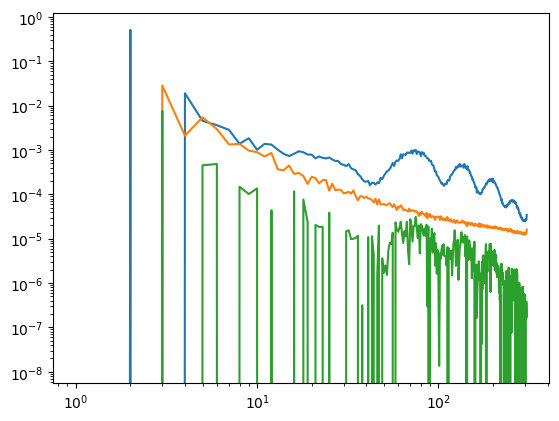

In [8]:
plt.loglog(s[3,3,0])
plt.loglog(s[3,3,1])
plt.loglog(s[3,3,2])

In [9]:
sat = SATsky(lib,nside,cb_method,dust,synch,alpha_sat,beta,atm_noise=atm_noise,nsplits=nsplits,bandpass=bandpass,deconv_maps=deconv_maps)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected
Mask : INFO - Downgrading mask SAT resolution
/pscratch/sd/l/lonappan/software_pkgs/cb/lib/python3.10/site-packages/so_models_v3/SO_Noise_Calculator_Public_v3_1_1.py:215: RuntimeWarning: divide by zero encountered in scalar divide
  cov_weight[i,j] += ( tube_count * N_tels /
Noise : INFO - Noise Model:[SAT] White + 1/f noise v3.1.1


In [10]:
satspectra = Spectra(sat,parallel=2,galcut=40,CO=False,PS=False,binwidth=5)

Mask : INFO - The given galactic cut value seems in percent of sky and it corresponds to 40% of sky
Mask : INFO - Loading composite mask
Mask : INFO - Downgrading mask SAT resolution
Mask : INFO - Downgrading mask GAL resolution
Mask : INFO - Composite Mask SATxGAL: fsky changed 0.12 -> 0.10  
Mask : INFO - Apodizing mask: scale 2.0: method: C2
Mask : INFO - Apodizing changed the fsky 0.103 -> 0.095
Spectra : INFO - Apodised mask saved to /pscratch/sd/l/lonappan/SOLATcalib/SAT_atm_noise_1splits/spectra_512_d_aposcale2p0_common/workspaces/mask_N512_aposcale2p0_G40.fits
Spectra : INFO - Computing coupling Matrix
Spectra : INFO - Coupling Matrix saved to /pscratch/sd/l/lonappan/SOLATcalib/SAT_atm_noise_1splits/spectra_512_d_aposcale2p0_common/workspaces/coupling_matrix_N512_fsky0p09_aposcale2p0_bw5_G40.fits
Spectra : INFO - Parallelized double loop


In [11]:
satspectra.load_obsQUmaps(0)

In [12]:
s = satspectra.obs_x_obs(0)

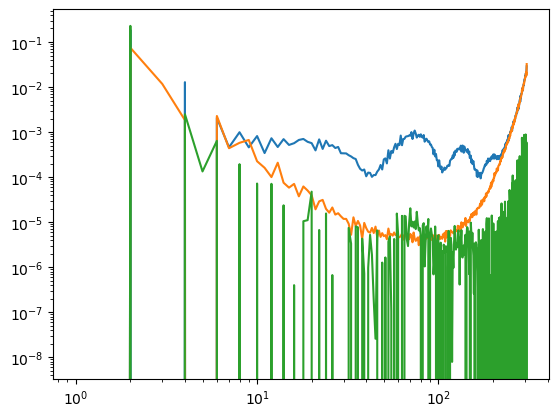

In [13]:
plt.loglog(s[3,3,0])
plt.loglog(s[3,3,1])
plt.loglog(s[3,3,2])